## This Notebook will aim to Optimize linear Models

I have a lot of different automatic results in the previous notebook so just manually take most optimal features and reduce from there



## Start with Naive Bayes


'avg3Months_Loan', 'avg3Months_DebtCollection', 'avg6Months_Loan', 'avg6Months_Gambling', 'avg_Gambling', 'avg_Salary', 'avg3Months_Deposit', 'avg3Months_Gambling','avg_Loan', 'avg_HousingCost', 'avg3Months_CashWithdrawal' ,'avg6Months_DirectDebit', 'avg_Gaming', 'avg3Months_Gaming', 'avg_CashWithdrawal', 'avg_OtherIncome', 'avg6Months_CashWithdrawal', 'avg6Months_InstallmentPayment', 'avg_DirectDebit', 'avg6Months_HousingCost', 'avg6Months_Gaming', 'avg3Months_DirectDebit'
'count_Loan', 'trend_DebtCollection', 'sum_Loan', 'trend_Deposit', 'sum_Gambling', 'count_Gambling', 'sum_Salary', 'trend_CashWithdrawal', 'sum_DirectDebit',

'sum installmentPayments', 'trend_Loan', 'Gambling_sum9Months', 'MoneyRemittance_monthlyAvg','trend_Salary', 'MoneyRemittance_partOfSalary9Months', 'Gambling_sum12Months', 'trend_MoneyRemittance', 'Crypto_count3Months', 'trend_OtherIncome', 'trend_PassiveIncome', 'Gambling_count9Months', 'Gambling_partOfSalary3Months', 'MoneyRemittance_category',

'DebtCollection_count9Months', 'CashWithdrawal_sum3Months'

'DebtCollection_sum3Months', 'DebtCollection_sum9Months', 'InstallmentPayment_count12Months', 'DebtCollection_partOfSalary12Months', 'DebtCollection_sum12Months', 'InstallmentPayment_count9Months',



In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sqlalchemy as sa
import pyodbc
import warnings
import urllib
warnings.filterwarnings('ignore')

path = "./Classes"
os.chdir(path)

from HYPERTUNNER import ModelOptimizer
from DATAPREPROCESSOR import DataPreprocessor
from MODEL_FEATURE_EVALUATOR import ModelEvaluator ,FeatureImportance


iterations = 200




################### GET PAYMENT DATA ##########################

path = "../../1. Data/Cleaned Transaction Data"
os.chdir(path)


df = pd.read_excel('PreeProcessed_Psd2.xlsx')
#df = df.drop(columns=['ReceivedDate','AccountNumber','ApplicationID','SSN','DisbursedDate','Amount','IsMainApplicant','ApplicantNo','NR','_merge','HasCoapp'])



In [2]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt


# Custom Gini coefficient scorer
def gini_scorer(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    return 2 * auc - 1

# Ensure the custom scorer is correctly created
gini_score = make_scorer(gini_scorer, needs_proba=True, greater_is_better=True)



# Function to plot Gini coefficient
def plot_gini(model, X_train, y_train, X_val, y_val, X_test, y_test, title):
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    gini_train = gini_scorer(y_train, y_train_pred_proba)
    gini_val = gini_scorer(y_val, y_val_pred_proba)
    gini_test = gini_scorer(y_test, y_test_pred_proba)
    
    auc_train = (gini_train + 1) / 2  # Convert Gini to AUC
    auc_val = (gini_val + 1) / 2  # Convert Gini to AUC
    auc_test = (gini_test + 1) / 2  # Convert Gini to AUC

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {auc_train:.2f}, Gini = {gini_train:.2f})')
    plt.plot(fpr_val, tpr_val, label=f'Validation ROC curve (AUC = {auc_val:.2f}, Gini = {gini_val:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {auc_test:.2f}, Gini = {gini_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show()




In [3]:
# df= df.iloc[:,:200]

In [3]:

# Reading the train.csv file into a DataFrame
train = pd.read_csv('train.csv')

# Reading the train.csv file into a DataFrame
val = pd.read_csv('val.csv')

# Reading the test.csv file into a DataFrame
test = pd.read_csv('test.csv')


In [5]:


preprocessor = DataPreprocessor(df)

all_features = df.drop(columns=['Ever90','ReceivedDate',	'ApplicationID','AccountNumber','SSN','DisbursedDate','Amount','IsMainApplicant','ApplicantNo','HasCoapp','NR']).columns ## DROP THESE SINCE THEY ARE JUST IDENTIFIERS   --'_merge',

input = df[['Ever90'] +list(all_features) ]

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  all_features ,scale = False)

input_dim = Xtrain.shape[1]

,avg_CashWithdrawal,avg_Crypto,avg_DebtCollection,avg_Deposit,avg_DirectDebit,avg_Gambling,avg_Gaming,avg_HousingCost,avg_InstallmentPayment,avg_InternalTransfer,...,Unclassified_partOfSalary9Months,Unclassified_sum12Months,Unclassified_sum3Months,Unclassified_sum6Months,Unclassified_sum9Months,sum creditors,sum debtCollectors,count creditors,count debtCollectors,_merge
0,1012,0,908,8528,0,636,0,0,5037,0,...,53052.0,100.0,100.0,100.0,100.0,701668,294047,380638,586716,0
1,791,0,762,1628,367,267,785,380,1584,0,...,111.8,139508.0,40730.0,81526.0,110687.0,0,0,0,0,0
2,1146,0,61,17145,225,89,25,7107,14597,0,...,54141.0,301.6,213.9,299.8,298.2,705394,121586,350300,516208,0
3,1959,0,299,2801,0,254,293,0,5050,0,...,150.5,443883.0,88587.0,217485.0,308314.0,0,0,0,0,0
4,8,0,0,3719,0,37,0,65,8723,0,...,130.1,222584.0,32568.0,66591.0,185114.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2367,0,0,0,756,0,0,0,0,1158,0,...,23872.0,165.2,47.0,117.4,153.1,321626,16749,108869,217967,0
2368,4851,0,0,9218,0,209,22,0,9437,0,...,16930.0,133.1,95.0,142.3,136.2,223432,36201,74311,153202,0
2369,0,0,200,1968,0,1721,654,3066,15289,0,...,140.9,218.6,233.7,528243.0,85423.0,256788,482350,0,0,0
2370,85,0,2540,384,0,59,146,0,6028,0,...,269.3,236.8,376.6,860834.0,119665.0,246092,641294,0,0,0


## Reduce dataset based on BRFS of RF as input into DL

In [6]:
selected = [ 'avg_Salary', 'avg3Months_CashWithdrawal',
       'avg3Months_Deposit', 'avg3Months_Loan', 'avg3Months_Salary',
       'avg6Months_Gambling', 'avg6Months_HousingCost',
       'avg6Months_Salary', 'count_Loan', 'sum_Salary', 'trend_Gaming',
       'trend_MobilePayment',  'Gambling_sum12Months',
       'CashWithdrawal_sum12Months', 'CashWithdrawal_sum6Months',
       'Gaming_count3Months', 'MobilePayment_partOfSalary6Months',
       'DebtCollection_count12Months', 
       'InstallmentPayment_count12Months',
       'InstallmentPayment_partOfSalary12Months',
       'HousingCost_count6Months', 'HousingCost_partOfSalary3Months',
       'DirectDebit_sum12Months', 'Unclassified_sum3Months']


# Goes in wrong direction 'DebtCollection_sum12Months', 'avg_Loan',



       

In [7]:
S_selected = selected #[:40]

In [10]:


input = df[['Ever90'] +list(S_selected) ]

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  all_features)

input_dim = Xtrain.shape[1]

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.feature_selection import SequentialFeatureSelector
from imblearn.over_sampling import RandomOverSampler

# Custom Gini scorer
def gini_score(y_true, y_pred):
    return 2 * roc_auc_score(y_true, y_pred) - 1

# Define the logistic regression model
logreg = LogisticRegression(random_state=42, max_iter=1000)

# Perform oversampling on the training data
oversampler = RandomOverSampler(random_state=420)
Xtrain_resampled, Ytrain_resampled = oversampler.fit_resample(Xtrain, Ytrain)

# Define the SequentialFeatureSelector object for forward feature selection
sfs = SequentialFeatureSelector(logreg, direction='forward', scoring=make_scorer(gini_score), cv=StratifiedKFold(3), n_jobs=-1)

# Perform forward feature selection on the resampled data
sfs.fit(Xtrain_resampled, Ytrain_resampled)

# Output the results
optimal_features = np.array(all_features)[sfs.get_support()]

# Transform the dataset to the optimal feature set
X_optimal = sfs.transform(Xtrain_resampled)

# Retrain the model with the optimal feature set
logreg.fit(X_optimal, Ytrain_resampled)

# Evaluate the final model
final_score = cross_val_score(logreg, X_optimal, Ytrain_resampled, cv=3, scoring=make_scorer(gini_score))
print("Final model Gini coefficient: %0.4f" % final_score.mean())

# Transform the test set using the selected features
X_train_optimal = sfs.transform(Xtrain)
X_val_optimal = sfs.transform(Xval)
X_test_optimal = sfs.transform(Xtest)


KeyboardInterrupt: 

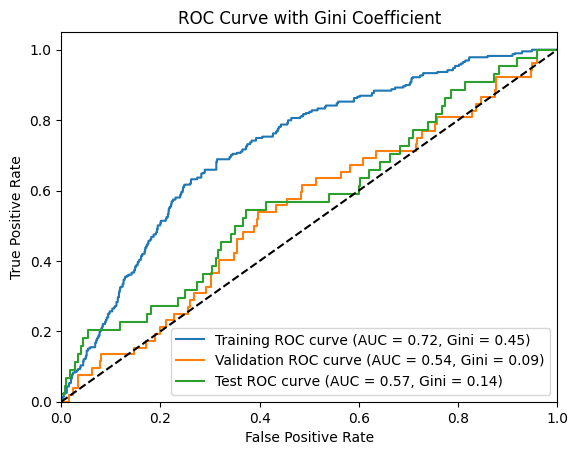

In [ ]:

# Plot for both the training and val sets
plot_gini(logreg, X_optimal, Ytrain_resampled, X_val_optimal, Yval, X_test_optimal, Ytest, "ROC Curve with Gini Coefficient")


In [ ]:
len(optimal_features)

134

Final model Gini coefficient: 0.2698


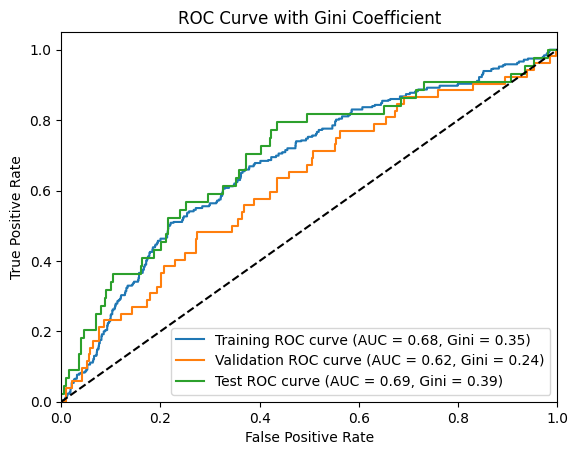

In [15]:

selected = [ 'avg3Months_CashWithdrawal',
       'avg3Months_Deposit', 'avg3Months_Loan', 'avg3Months_Salary',
       'avg6Months_Gambling', 'avg6Months_HousingCost',
       'avg6Months_Salary', 'count_Loan', 'sum_Salary', 'trend_Gaming',
       'trend_MobilePayment', 'Gambling_sum12Months',
       'CashWithdrawal_sum12Months', 
       'Gaming_count3Months', 'MobilePayment_partOfSalary6Months',
       'DebtCollection_count12Months', 'DebtCollection_sum12Months',
       'InstallmentPayment_count12Months',
      
      
      'Unclassified_sum3Months'
       
    #    ## Test these also
    #      ,'avg_Gambling', 
    #   'avg6Months_Loan', 
      , 'count_PassiveIncome', 
    #   'sum_OtherIncome',
     #  'trend_DebtCollection',
        'trend_Salary',
     #   'CashWithdrawal_count6Months',
     #   'MobilePayment_count12Months',
       # 'DebtCollection_sum3Months'
       
       
       ]



###'trend_DebtCollection',   'DebtCollection_sum12Months',      'avg_Loan',              'count_Gambling','sum_Gaming', 'HousingCost_count6Months',      'HousingCost_partOfSalary3Months','CashWithdrawal_sum6Months',  'InstallmentPayment_partOfSalary12Months',



### 'avg_Salary',  



selected = selected
       
input = df[['Ever90'] +list(selected) ]

preprocessor = DataPreprocessor(input)

all_features = df.drop(columns=['Ever90','ReceivedDate',	'ApplicationID','AccountNumber','SSN','DisbursedDate','Amount','IsMainApplicant','ApplicantNo','HasCoapp','NR']).columns ## DROP THESE SINCE THEY ARE JUST IDENTIFIERS   --'_merge',



## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  selected,scale = False)


import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.feature_selection import SequentialFeatureSelector
from imblearn.over_sampling import RandomOverSampler

# Custom Gini scorer
def gini_score(y_true, y_pred):
    return 2 * roc_auc_score(y_true, y_pred) - 1

# Define the logistic regression model
logreg = LogisticRegression(random_state=42, max_iter=100000)

# Perform oversampling on the training data
oversampler = RandomOverSampler(random_state=420)
Xtrain_resampled, Ytrain_resampled = oversampler.fit_resample(Xtrain, Ytrain)

# Define the SequentialFeatureSelector object for forward feature selection
sfs = SequentialFeatureSelector(logreg, direction='forward', scoring=make_scorer(gini_score), cv=StratifiedKFold(3), n_jobs=-1)

# Perform forward feature selection on the resampled data
sfs.fit(Xtrain_resampled, Ytrain_resampled)

# Output the results
optimal_features = np.array(selected)[sfs.get_support()]

# Transform the dataset to the optimal feature set
X_optimal = sfs.transform(Xtrain_resampled)

# Retrain the model with the optimal feature set
logreg.fit(X_optimal, Ytrain_resampled)

# Evaluate the final model
final_score = cross_val_score(logreg, X_optimal, Ytrain_resampled, cv=3, scoring=make_scorer(gini_score))
print("Final model Gini coefficient: %0.4f" % final_score.mean())

# Transform the test set using the selected features
X_train_optimal = sfs.transform(Xtrain)
X_val_optimal = sfs.transform(Xval)
X_test_optimal = sfs.transform(Xtest)


# Plot for both the training and val sets
plot_gini(logreg, X_optimal, Ytrain_resampled, X_val_optimal, Yval, X_test_optimal, Ytest, "ROC Curve with Gini Coefficient")









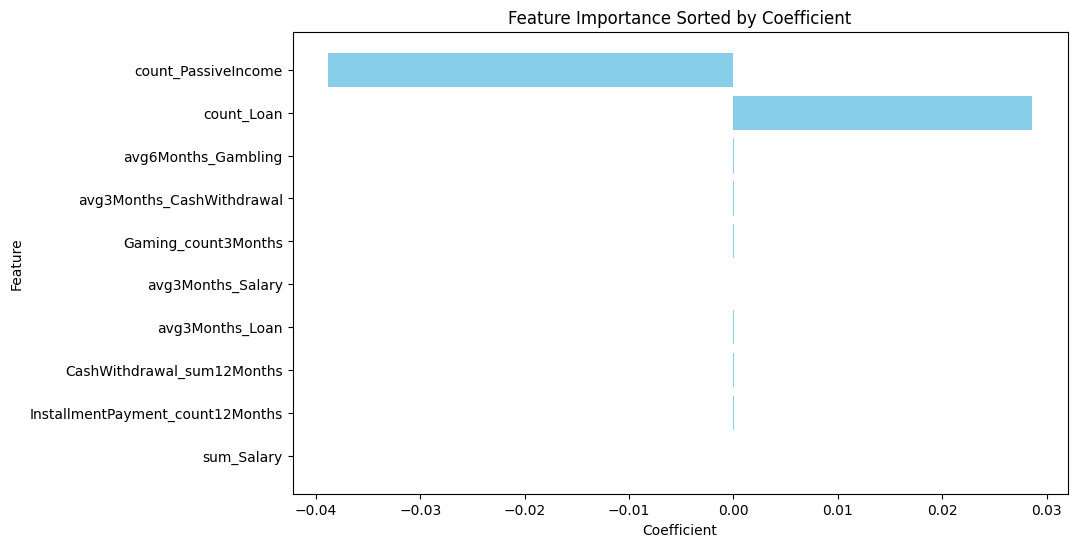

In [17]:
# Create a DataFrame to hold the features and their corresponding coefficients
feature_importance = pd.DataFrame({
    'Feature': optimal_features,
    'Coefficient': logreg.coef_[0]
})

# Sort the DataFrame by the absolute value of the coefficients in descending order
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Plot the bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importance Sorted by Coefficient')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

,avg3Months_CashWithdrawal,avg3Months_Loan,avg3Months_Salary,avg6Months_Gambling,count_Loan,sum_Salary,CashWithdrawal_sum12Months,Gaming_count3Months,InstallmentPayment_count12Months,count_PassiveIncome
0,0,2733,10998,0,9,281381,0.0,0,2872,0
1,1166,0,15810,153858,24,201297,4.9,0,10772,0
2,6733,2212,22387,683,35,272161,36.3,42100,2584,1
3,0,266,18721,1456,25,214204,33.6,0,9496,0
4,0,0,28368,3844,24,363693,38.0,0,180,0
...,...,...,...,...,...,...,...,...,...,...
3488,3480,0,17008,0,5,135672,15762.0,4,66,9
3489,4533,0,19984,0,2,288782,16000.0,0,72,1
3490,0,0,36136,0,4,307965,0.1,0,14315,0
3491,0,0,49471,410,0,505149,0.0,0,0,3


In [22]:
optimal_features

array(['avg3Months_CashWithdrawal', 'avg3Months_Loan',
       'avg3Months_Salary', 'avg6Months_Gambling', 'count_Loan',
       'sum_Salary', 'CashWithdrawal_sum12Months', 'Gaming_count3Months',
       'InstallmentPayment_count12Months', 'count_PassiveIncome'],
      dtype='<U33')

In [7]:
import joblib

path = "../../2. Python/Finished Models"
os.chdir(path)


import joblib

# Save the model and features
joblib.dump(logreg, os.path.join( 'lg_model_1.pkl'))

joblib.dump(optimal_features, os.path.join('optimal_features_lg_model_1.pkl'))

print("Model and features have been saved to Python/Finished Models.")

Model and features have been saved to Python/Finished Models.


In [17]:
data

{'avg3Months_CashWithdrawal': [0, 1166],
 'avg3Months_Loan': [2733, 0],
 'avg3Months_Salary': [10998, 15810],
 'avg6Months_Gambling': [0, 153858],
 'count_Loan': [9, 24],
 'sum_Salary': [281381, 201297],
 'CashWithdrawal_sum12Months': [0.0, 4.9],
 'Gaming_count3Months': [0, 0],
 'InstallmentPayment_count12Months': [2872, 10772],
 'count_PassiveIncome': [0, 0]}

In [87]:
inp = df[optimal_features]


def getReason(logreg,df):

    """ Calculate Normalized Feature Contribution to each score """

    abs_coefNweight = np.abs(logreg.coef_[0] * df)
    abs_coefNweight['sum_absCoef'] = abs_coefNweight.sum(axis=1)

    relative = pd.DataFrame()

    for i in abs_coefNweight.columns:
        if i != 'sum_absCoef': relative[i] = abs_coefNweight[i] / abs_coefNweight['sum_absCoef']

    return relative



In [91]:
def getReason(logreg,df):

    """ Calculate Normalized Feature Contribution to each score """

    coefNweight = logreg.coef_[0] * df
    abs_coefNweight = np.abs(logreg.coef_[0] * df)
    abs_coefNweight['sum_absCoef'] = abs_coefNweight.sum(axis=1)

    relative = pd.DataFrame()

    for i in abs_coefNweight.columns:
        if i != 'sum_absCoef': relative[i] = coefNweight[i] / abs_coefNweight['sum_absCoef']

    return relative

In [92]:
getReason(logreg,inp)

,avg3Months_CashWithdrawal,avg3Months_Loan,avg3Months_Salary,avg6Months_Gambling,count_Loan,sum_Salary,CashWithdrawal_sum12Months,Gaming_count3Months,InstallmentPayment_count12Months,count_PassiveIncome
0,0.000000,0.018462,-0.098169,0.000000,0.296641,-0.573348,0.000000e+00,0.000000,0.013381,-0.000000
1,0.004617,0.000000,-0.013202,0.865109,0.074003,-0.038372,2.715461e-06,0.000000,0.004695,-0.000000
2,0.095432,0.005004,-0.066922,0.013748,0.386341,-0.185722,7.201458e-05,0.227740,0.004032,-0.014986
3,0.000000,0.001151,-0.107028,0.056049,0.527759,-0.279549,1.274812e-04,0.000000,0.028336,-0.000000
4,0.000000,0.000000,-0.125514,0.114522,0.392104,-0.367333,1.115796e-04,0.000000,0.000416,-0.000000
...,...,...,...,...,...,...,...,...,...,...
3488,0.119081,0.000000,-0.122745,0.000000,0.133244,-0.223514,7.549207e-02,0.000052,0.000249,-0.325623
3489,0.164756,0.000000,-0.153188,0.000000,0.056611,-0.505331,8.139579e-02,0.000000,0.000288,-0.038429
3490,0.000000,0.000000,-0.280822,0.000000,0.114783,-0.546330,5.157384e-07,0.000000,0.058064,-0.000000
3491,0.000000,0.000000,-0.270947,0.015120,0.000000,-0.631562,0.000000e+00,0.000000,0.000000,-0.082371


In [74]:
abs_coefNweight

,avg3Months_CashWithdrawal,avg3Months_Loan,avg3Months_Salary,avg6Months_Gambling,count_Loan,sum_Salary,CashWithdrawal_sum12Months,Gaming_count3Months,InstallmentPayment_count12Months,count_PassiveIncome,sum_absCoef
0,0.000000,0.016034,0.085260,0.000000,0.257633,0.497954,0.000000e+00,0.000000,0.011621,0.000000,0.868502
1,0.042859,0.000000,0.122564,8.031441,0.687021,0.356231,2.520960e-05,0.000000,0.043587,0.000000,9.283728
2,0.247487,0.012978,0.173551,0.035653,1.001905,0.481637,1.867568e-04,0.590602,0.010456,0.038864,2.593320
3,0.000000,0.001561,0.145131,0.076004,0.715647,0.379072,1.728658e-04,0.000000,0.038424,0.000000,1.356011
4,0.000000,0.000000,0.219918,0.200658,0.687021,0.643619,1.955030e-04,0.000000,0.000728,0.000000,1.752140
...,...,...,...,...,...,...,...,...,...,...,...
3488,0.127915,0.000000,0.131851,0.000000,0.143129,0.240096,8.109260e-02,0.000056,0.000267,0.349780,1.074187
3489,0.166621,0.000000,0.154922,0.000000,0.057252,0.511051,8.231707e-02,0.000000,0.000291,0.038864,1.011318
3490,0.000000,0.000000,0.280138,0.000000,0.114503,0.544999,5.144817e-07,0.000000,0.057923,0.000000,0.997563
3491,0.000000,0.000000,0.383515,0.021402,0.000000,0.893951,0.000000e+00,0.000000,0.000000,0.116593,1.415461


In [53]:
logreg.coef_[0][5] * 281381

10.342798479798319

In [52]:
logreg.coef_[0][5] * 201297

-0.35623074785104103

In [46]:
import numpy as np
import pandas as pd

# Example input data
data = {
    'avg3Months_CashWithdrawal': [0, 1166],
    'avg3Months_Loan': [2733, 0],
    'avg3Months_Salary': [10998, 15810],
    'avg6Months_Gambling': [0, 153858],
    'count_Loan': [9, 24],
    'sum_Salary': [281381, 201297],
    'CashWithdrawal_sum12Months': [0.0, 4.9],
    'Gaming_count3Months': [0, 0],
    'InstallmentPayment_count12Months': [2872, 10772],
    'count_PassiveIncome': [0, 0]
}

input_df = pd.DataFrame(data)

# List of features based on optimal_features from SequentialFeatureSelector
optimal_features = [
    'avg3Months_CashWithdrawal', 'avg3Months_Loan',
    'avg3Months_Salary', 'avg6Months_Gambling', 'count_Loan',
    'sum_Salary', 'CashWithdrawal_sum12Months', 'Gaming_count3Months',
    'InstallmentPayment_count12Months', 'count_PassiveIncome'
]

# Ensure we use only the selected optimal features
input_df = input_df[optimal_features]

# Function to calculate the contribution of each feature to the predicted score
def calculate_contribution(model, features_df, features):
    # Get the coefficients from the model
    coefficients = model.coef_[0]
    
    # Calculate the contribution of each feature
    contributions = features_df.values * coefficients
    
    # Calculate the absolute value of the contributions
    abs_contributions = np.abs(contributions)
    
    # Sum the absolute contributions to get the total contribution for each data point
    total_abs_contributions = np.sum(abs_contributions, axis=1, keepdims=True)
    
    # Normalize the contributions so each row sums to 1
    normalized_contributions = abs_contributions / total_abs_contributions
    
    # Create a DataFrame to hold the features and their contributions
    contribution_df = pd.DataFrame(normalized_contributions, columns=features)
    
    return contribution_df, contributions, abs_contributions, total_abs_contributions

# Calculate the contributions for each input data point
feature_contributions, contributions, abs_contributions, total_abs_contributions = calculate_contribution(logreg, input_df, optimal_features)
feature_contributions

,avg3Months_CashWithdrawal,avg3Months_Loan,avg3Months_Salary,avg6Months_Gambling,count_Loan,sum_Salary,CashWithdrawal_sum12Months,Gaming_count3Months,InstallmentPayment_count12Months,count_PassiveIncome
0,0.000000,0.018462,0.098169,0.000000,0.296641,0.573348,0.000000,0.0,0.013381,0.0
1,0.004617,0.000000,0.013202,0.865109,0.074003,0.038372,0.000003,0.0,0.004695,0.0


In [48]:
model.coef_[0]

NameError: name 'model' is not defined

In [18]:
optimal_features

array(['avg3Months_CashWithdrawal', 'avg3Months_Loan',
       'avg3Months_Salary', 'avg6Months_Gambling', 'count_Loan',
       'sum_Salary', 'CashWithdrawal_sum12Months', 'Gaming_count3Months',
       'InstallmentPayment_count12Months', 'count_PassiveIncome'],
      dtype='<U33')

In [29]:
df[optimal_features]

,avg3Months_CashWithdrawal,avg3Months_Loan,avg3Months_Salary,avg6Months_Gambling,count_Loan,sum_Salary,CashWithdrawal_sum12Months,Gaming_count3Months,InstallmentPayment_count12Months,count_PassiveIncome
0,0,2733,10998,0,9,281381,0.0,0,2872,0
1,1166,0,15810,153858,24,201297,4.9,0,10772,0
2,6733,2212,22387,683,35,272161,36.3,42100,2584,1
3,0,266,18721,1456,25,214204,33.6,0,9496,0
4,0,0,28368,3844,24,363693,38.0,0,180,0
...,...,...,...,...,...,...,...,...,...,...
3488,3480,0,17008,0,5,135672,15762.0,4,66,9
3489,4533,0,19984,0,2,288782,16000.0,0,72,1
3490,0,0,36136,0,4,307965,0.1,0,14315,0
3491,0,0,49471,410,0,505149,0.0,0,0,3


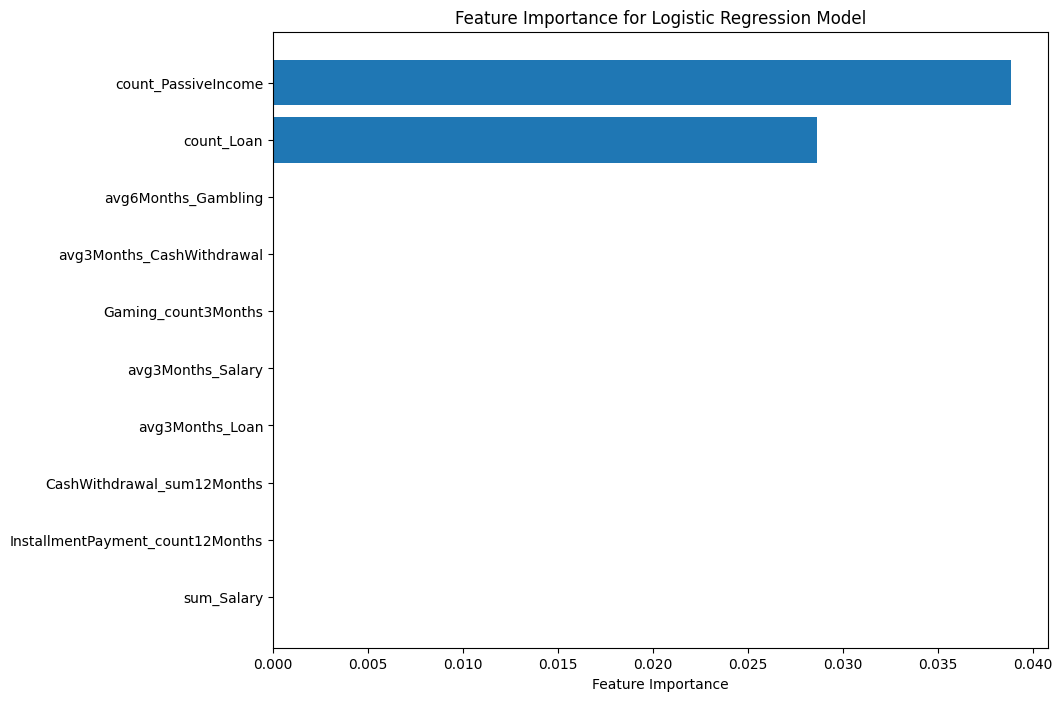

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `logreg` is your trained logistic regression model
# `selected` is your list of selected features
# `sfs` is the SequentialFeatureSelector object

# Getting the feature importance
feature_importance = np.abs(logreg.coef_[0])
feature_names = np.array(selected)[sfs.get_support()]

# Sorting the feature importances in descending order
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_idx]
sorted_feature_names = feature_names[sorted_idx]

# Plotting the feature importance
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_feature_importance, align='center')
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Logistic Regression Model')
plt.gca().invert_yaxis()
plt.show()


In [46]:
feature_importance

,Feature,Coefficient,Abs_Coefficient
6,count_Loan,0.443567,0.443567
3,avg3Months_Loan,0.239725,0.239725
7,sum_Salary,-0.211054,0.211054
0,avg_Loan,-0.170427,0.170427
12,count_PassiveIncome,-0.169618,0.169618
9,Gaming_count3Months,0.164732,0.164732
5,avg6Months_Gambling,0.144388,0.144388
8,trend_Gaming,0.101095,0.101095
2,avg3Months_Deposit,0.096307,0.096307
1,avg3Months_CashWithdrawal,0.075063,0.075063


In [24]:
df

,ReceivedDate,ApplicationID,AccountNumber,SSN,DisbursedDate,Amount,IsMainApplicant,ApplicantNo,HasCoapp,Ever90,...,Unclassified_partOfSalary9Months,Unclassified_sum12Months,Unclassified_sum3Months,Unclassified_sum6Months,Unclassified_sum9Months,sum creditors,sum debtCollectors,count creditors,count debtCollectors,_merge
0,2022-03-08,8205045,0,7711025523,2022-03-10,250000,1,1,0,1,...,50227.0,224.1,248.5,247.0,258.4,630444,81995,288551,519248,0
1,2022-04-07,8228347,0,9804048719,2022-04-22,400000,1,1,1,1,...,763.7,1333.3,1553.4,2678645.0,241491.0,1655157,2249127,0,0,0
2,2022-04-08,8229075,0,6501225061,2022-04-12,240000,1,1,0,1,...,85589.0,322.8,415.5,320.5,331.8,882268,279047,442904,685525,0
3,2022-04-11,8230481,0,9606236371,2022-04-13,295000,1,1,0,1,...,268.0,476.0,439.5,883993.0,100348.0,452428,627919,0,0,0
4,2022-04-15,8233936,0,8602147608,2022-06-08,270000,1,1,0,1,...,379.3,1362741.0,251386.0,547363.0,971946.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3488,2023-04-28,8660675,0,8902289209,2023-05-31,271000,1,1,1,0,...,195.3,381102.0,84024.0,274075.0,312523.0,0,0,0,0,0
3489,2023-04-28,8660675,0,8903213695,2023-05-31,271000,0,2,1,0,...,121.2,348937.0,91087.0,215240.0,265065.0,0,0,0,0,0
3490,2023-04-28,8660600,0,8007075586,2023-05-08,350000,1,1,1,0,...,40754.0,165.3,135.9,130.5,145.1,509094,147353,245526,367844,0
3491,2023-04-28,8660600,0,8203014934,2023-05-08,350000,0,2,1,0,...,38839.0,96.0,76.7,72.3,92.7,487593,113811,198074,353883,0


In [23]:
list(feature_importance['Feature'])
find_mean = df[list(feature_importance['Feature'])]
#find_mean.groupby(['']) nfind mean aof each feature

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [42]:
 find_mean.mean()

count_Loan                               6.503865
avg3Months_Loan                       4456.348697
sum_Salary                          274067.065273
avg_Loan                              4600.898941
count_PassiveIncome                      1.664186
Gaming_count3Months                   3627.430003
avg6Months_Gambling                    956.885485
trend_Gaming                            68.437733
avg3Months_Deposit                    4062.698254
avg3Months_CashWithdrawal             1139.589178
avg3Months_Salary                    23933.422559
InstallmentPayment_count12Months      6370.288005
DirectDebit_sum12Months                613.732265
dtype: float64

In [48]:
logreg.coef_[0]

array([-0.17042669,  0.07506302,  0.09630713,  0.23972534, -0.07380909,
        0.14438777,  0.44356723, -0.21105415,  0.10109452,  0.16473157,
        0.0681847 ,  0.0450478 , -0.16961834])

In [49]:
274067 * 0.09630713

26394.60619771

In [22]:
# Calculate the mean of each feature
mean_values = find_mean.mean()

importance_values = mean_values * logreg.coef_[0]

# Create a DataFrame to hold the feature importance values
importance_df = pd.DataFrame({
    'Feature': optimal_features,
    'Importance': importance_values
})

# Sort the DataFrame by the absolute value of the importance in descending order
importance_df['Abs_Importance'] = importance_df['Importance'].abs()
importance_df = importance_df.sort_values(by='Abs_Importance', ascending=False)

# Plot the sorted feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center', color='skyblue')
plt.xlabel('Importance (Mean * Coefficient)')
plt.title('Feature Importance for Logistic Regression Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

NameError: name 'find_mean' is not defined

Model and features have been saved to Python/Finished Models.


In [9]:
len( selected)

55

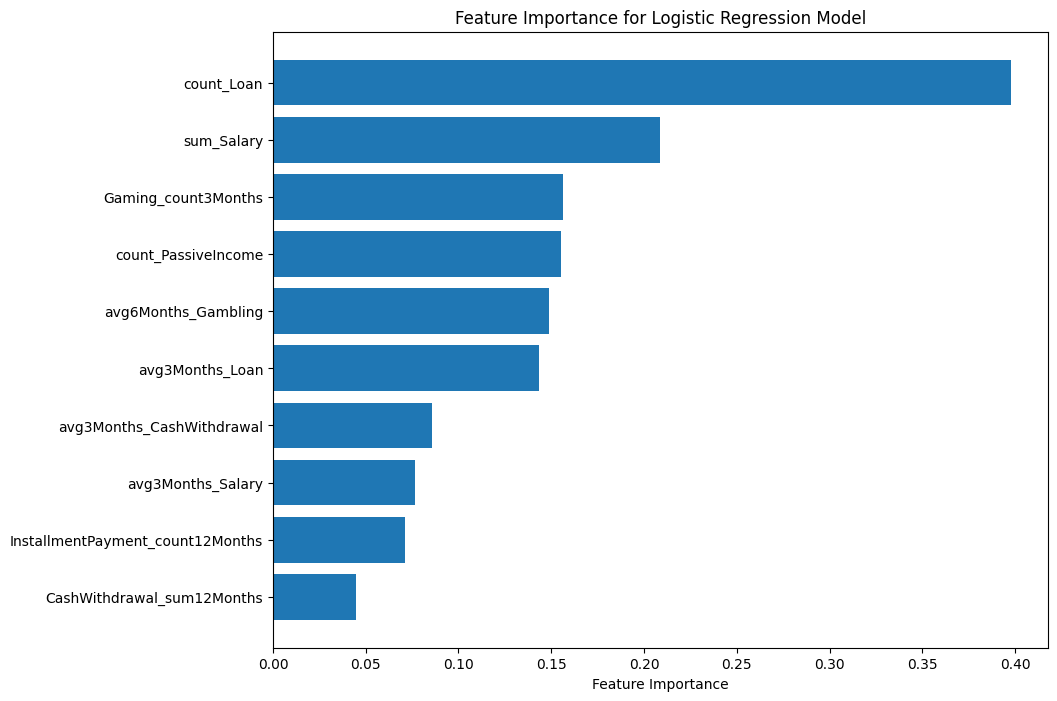

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `logreg` is your trained logistic regression model
# `selected` is your list of selected features
# `sfs` is the SequentialFeatureSelector object

# Getting the feature importance
feature_importance = np.abs(logreg.coef_[0])
feature_names = np.array(selected)[sfs.get_support()]

# Sorting the feature importances in descending order
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_idx]
sorted_feature_names = feature_names[sorted_idx]

# Plotting the feature importance
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_feature_importance, align='center')
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Logistic Regression Model')
plt.gca().invert_yaxis()
plt.show()


In [8]:
sorted_feature_names

array(['count_Loan', 'avg_Salary', 'avg_Loan', 'Gaming_count3Months',
       'avg_Gambling', 'count_PassiveIncome', 'DebtCollection_sum3Months',
       'avg6Months_Loan', 'avg3Months_Loan', 'trend_Gaming',
       'InstallmentPayment_count12Months', 'trend_Salary',
       'trend_DebtCollection', 'MobilePayment_count12Months',
       'sum_OtherIncome', 'DebtCollection_sum12Months',
       'CashWithdrawal_sum12Months', 'avg6Months_Salary',
       'CashWithdrawal_count6Months', 'trend_MobilePayment', 'sum_Salary',
       'avg6Months_Gambling'], dtype='<U34')

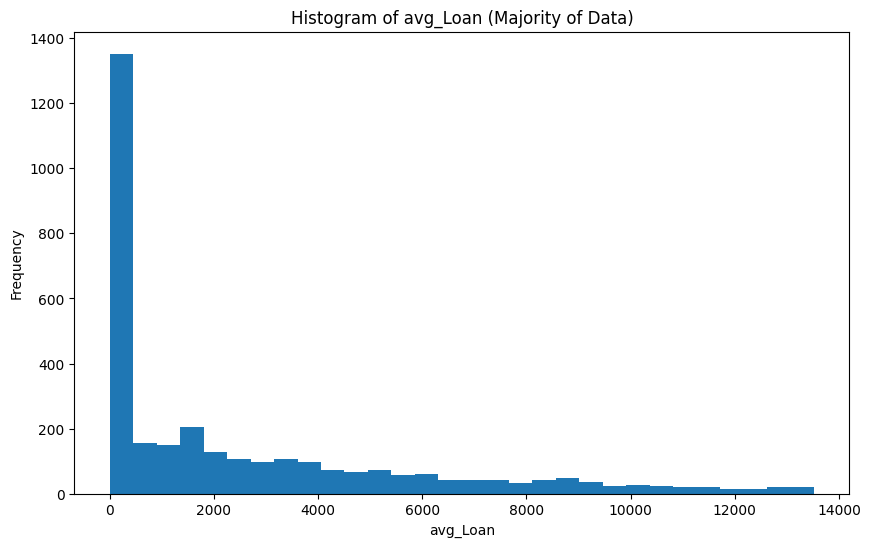

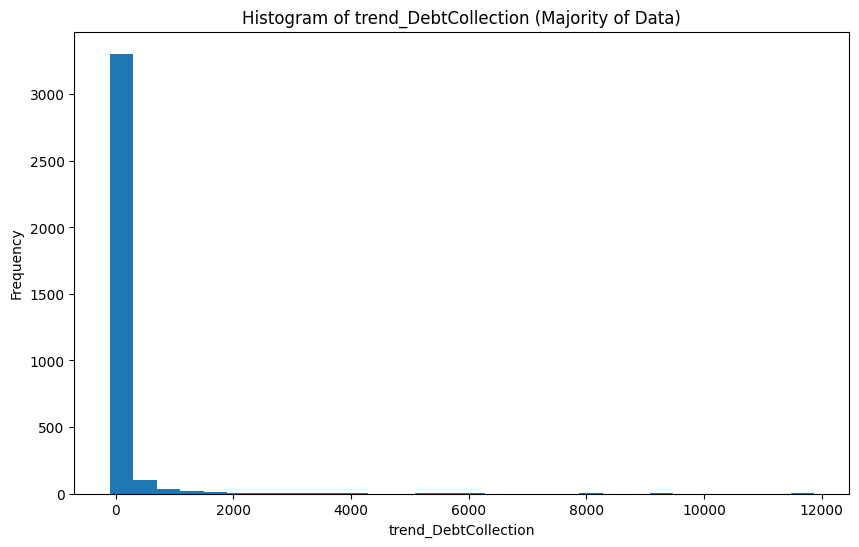

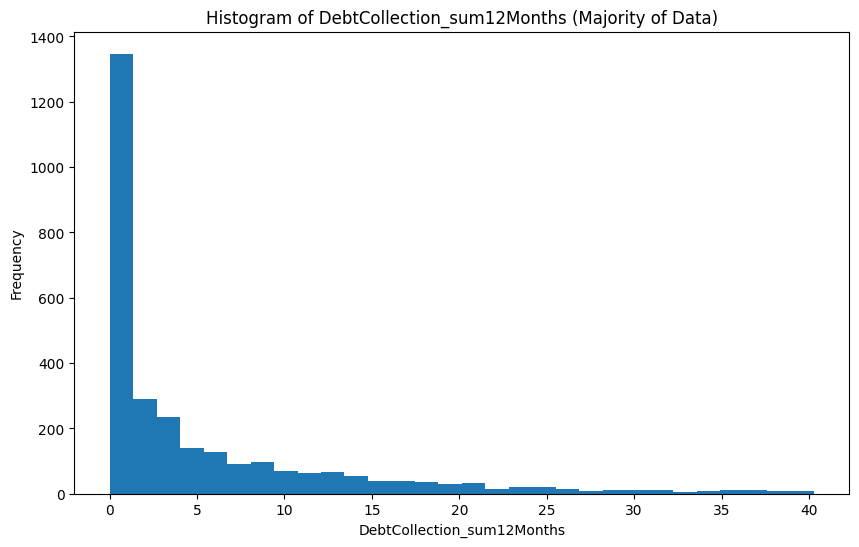

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and avg_Loan is the column of interest

# Calculate the interquartile range (IQR)
Q1 = df['avg_Loan'].quantile(0.25)
Q3 = df['avg_Loan'].quantile(0.75)
IQR = Q3 - Q1

# Define the range to plot
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the data to include only the majority range
filtered_data = df[(df['avg_Loan'] >= lower_bound) & (df['avg_Loan'] <= upper_bound)]

# Plot the histogram
plt.figure(figsize=(10, 6))
filtered_data['avg_Loan'].hist(bins=30)
plt.title('Histogram of avg_Loan (Majority of Data)')
plt.xlabel('avg_Loan')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()


import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and avg_Loan is the column of interest

# Calculate the interquartile range (IQR)
Q1 = df['avg_Loan'].quantile(0.25)
Q3 = df['avg_Loan'].quantile(0.75)
IQR = Q3 - Q1

# Define the range to plot
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the data to include only the majority range
filtered_data = df[(df['trend_DebtCollection'] >= lower_bound) & (df['trend_DebtCollection'] <= upper_bound)]

# Plot the histogram
plt.figure(figsize=(10, 6))
filtered_data['trend_DebtCollection'].hist(bins=30)
plt.title('Histogram of trend_DebtCollection (Majority of Data)')
plt.xlabel('trend_DebtCollection')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()


import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and avg_Loan is the column of interest

# Calculate the interquartile range (IQR)
Q1 = df['DebtCollection_sum12Months'].quantile(0.25)
Q3 = df['DebtCollection_sum12Months'].quantile(0.75)
IQR = Q3 - Q1

# Define the range to plot
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the data to include only the majority range
filtered_data = df[(df['DebtCollection_sum12Months'] >= lower_bound) & (df['DebtCollection_sum12Months'] <= upper_bound)]

# Plot the histogram
plt.figure(figsize=(10, 6))
filtered_data['DebtCollection_sum12Months'].hist(bins=30)
plt.title('Histogram of DebtCollection_sum12Months (Majority of Data)')
plt.xlabel('DebtCollection_sum12Months')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()



In [ ]:
optimal_features = np.array(['avg_Gambling', 'avg_Loan', 'avg_Salary', 'avg3Months_Loan', 'avg6Months_Gambling',

                              'avg6Months_Loan', 'avg6Months_Salary','count_Loan', 'count_PassiveIncome', 'sum_OtherIncome',

                             'sum_Salary', 'trend_DebtCollection', 'trend_Gaming','trend_MobilePayment', 'trend_Salary',

                             'CashWithdrawal_count6Months', 'CashWithdrawal_sum12Months','Gaming_count3Months', 'MobilePayment_count12Months','DebtCollection_sum12Months',
                             
                              'DebtCollection_sum3Months','InstallmentPayment_count12Months'], dtype='<U34')



coefficients = np.array([0.20100291, -0.24858901, -0.29347181, 0.14550487, 0.00681456,    ## ALL LOGICAL BUT 'avg_Loan',

                         0.15083461, -0.02627139, 0.40506997, -0.15271636, -0.05528426,

                         -0.00796284, -0.10398583, 0.12539363, 0.0096969, -0.11548425,    ## trend_DebtCollection 

                         0.02380453, 0.0483669, 0.21013957, -0.08297159, -0.05175224,
                         0.15239095, 0.11582265])

In [ ]:
df

In [93]:
import joblib

path = "../../2. Python/Finished Models"
os.chdir(path)


import joblib

# Save the model and features
joblib.dump(logreg, os.path.join( 'lg_model_1.pkl'))

joblib.dump(optimal_features, os.path.join('optimal_features_lg_model_1.pkl'))

print("Model and features have been saved to Python/Finished Models.")

Model and features have been saved to Python/Finished Models.


In [37]:
from sklearn.preprocessing import StandardScaler

# Assuming Xtrain, Xval, and Xtest are defined earlier
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xval_scaled = scaler.transform(Xval)
Xtest_scaled = scaler.transform(Xtest)

# Perform oversampling on the scaled training data
Xtrain_resampled, Ytrain_resampled = oversampler.fit_resample(Xtrain_scaled, Ytrain)

# Redefine and fit the SFS on the resampled scaled data
sfs.fit(Xtrain_resampled, Ytrain_resampled)

# Get the optimal features and transform the data
optimal_features = np.array(selected)[sfs.get_support()]
X_optimal = sfs.transform(Xtrain_resampled)

# Retrain the model
logreg.fit(X_optimal, Ytrain_resampled)

# Transform validation and test sets using the selected features
X_train_optimal = sfs.transform(Xtrain_scaled)
X_val_optimal = sfs.transform(Xval_scaled)
X_test_optimal = sfs.transform(Xtest_scaled)


In [38]:
X_train_optimal

array([[-0.2021692 , -0.18861432, -2.44691041, ...,  0.04099004,
        -0.2055623 , -0.42348749],
       [-0.4563197 , -0.09607424, -1.42302932, ..., -0.33727591,
        -0.3451005 ,  2.82736148],
       [-0.13820514,  0.17778555, -0.51508816, ...,  0.03352545,
        -0.34754256, -0.42348749],
       ...,
       [-0.48616959, -0.14835284, -0.55332692, ..., -0.33970415,
        -0.18852467,  1.32696965],
       [-0.34416939,  0.42912343, -0.18134025, ..., -0.33970415,
         1.51586318, -0.42348749],
       [-0.48616959, -0.19143467, -1.39366195, ..., -0.33925447,
        -0.3451005 , -0.42348749]])